In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE = 128
BATCH_SIZE = 16
CHANNEL_SIZE = 3
ds = tf.keras.preprocessing.image_dataset_from_directory("image_data/", shuffle=True, image_size=(IMAGE_SIZE,IMAGE_SIZE)
                                                         , batch_size=BATCH_SIZE)

Found 16011 files belonging to 10 classes.


In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
class_names = ds.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
len(ds)

1001

In [6]:
68*32

2176

In [7]:
for image_batch, label_batch in ds.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(16, 128, 128, 3)
[0 7 0 7 3 6 0 4 7 7 5 5 1 7 9 0]


In [8]:
for image_batch, label_batch in ds.take(1):
    print(image_batch[0])
    print(label_batch[0].numpy())

tf.Tensor(
[[[156.75 144.75 154.75]
  [153.25 141.25 151.25]
  [152.75 140.75 150.75]
  ...
  [156.5  143.   154.5 ]
  [158.   145.   154.25]
  [157.   144.   151.  ]]

 [[160.   148.   158.  ]
  [156.   144.   154.  ]
  [153.5  141.5  151.5 ]
  ...
  [156.75 143.5  154.25]
  [152.75 139.75 148.75]
  [160.   147.   154.5 ]]

 [[161.25 149.25 159.25]
  [158.75 146.75 156.75]
  [155.25 143.25 153.25]
  ...
  [153.25 140.25 150.25]
  [158.75 145.75 155.5 ]
  [160.25 147.25 156.25]]

 ...

 [[198.   188.   199.  ]
  [196.25 186.25 197.25]
  [198.25 188.25 199.25]
  ...
  [199.25 189.25 198.25]
  [204.75 194.75 203.75]
  [206.25 196.25 205.25]]

 [[197.75 187.75 198.75]
  [194.   184.   195.  ]
  [195.25 185.25 196.25]
  ...
  [201.5  191.5  200.5 ]
  [200.75 190.75 199.75]
  [201.75 191.75 200.75]]

 [[198.25 188.25 199.25]
  [198.75 188.75 199.75]
  [191.5  181.5  192.5 ]
  ...
  [201.25 191.25 200.25]
  [198.   188.   197.  ]
  [203.25 193.25 202.25]]], shape=(128, 128, 3), dtype=float32

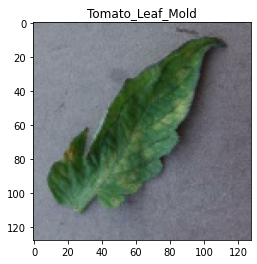

In [9]:
for image_batch, label_batch in ds.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])

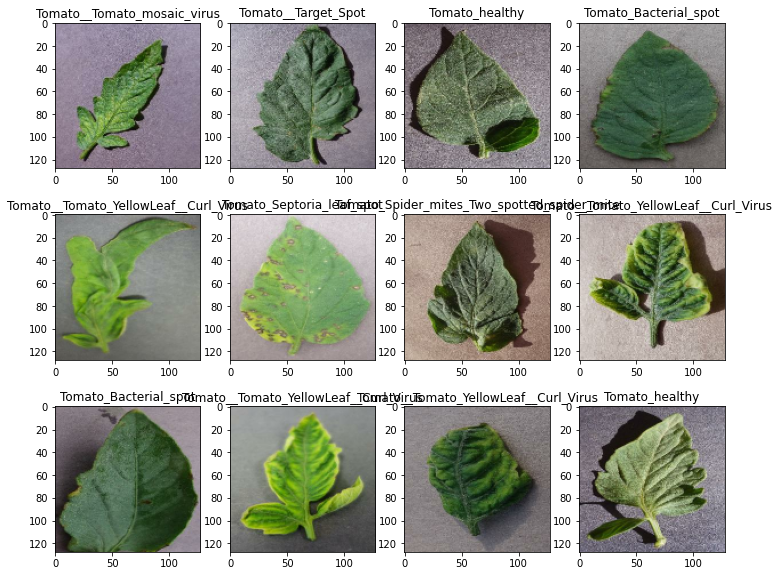

In [10]:
plt.figure(figsize=(12,10))
for image_batch, label_batch in ds.take(1):
    for i in range(12):
        plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])

In [11]:
train_size = 0.8
validation_size = 0.1
test_size = 0.1

In [12]:
train_ds = ds.take(int(len(ds)*train_size))
len(train_ds)

800

In [13]:
valid_plus_test_ds = ds.skip(int(len(ds)*train_size))
len(valid_plus_test_ds)

201

In [14]:
valid_ds = valid_plus_test_ds.take(int(len(ds)*validation_size))
len(valid_ds)

100

In [15]:
test_ds = valid_plus_test_ds.skip(int(len(ds)*validation_size))
len(test_ds)

101

In [16]:
def train_valid_test(dataset, train_size = 0.750, validation_size = 0.125, test_size = 0.125,shuffle=True, shuffle_size=10000):
    ds_size = len(dataset)
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=0)
    train_ds = dataset.take(int(ds_size*train_size))
    valid_plus_test_ds = dataset.skip(int(ds_size*train_size))
    valid_ds = valid_plus_test_ds.take(int(ds_size*validation_size))
    test_ds = valid_plus_test_ds.skip(int(ds_size*validation_size))
    return train_ds, valid_ds, test_ds

In [17]:
train_ds, valid_ds, test_ds = train_valid_test(dataset=ds)

In [18]:
len(train_ds)

750

In [19]:
len(valid_ds)

125

In [20]:
len(test_ds)

126

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [23]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(),
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2,0.5)
])

In [24]:
tf.keras.backend.clear_session()
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(filters=256, kernel_size=(3,3), activation="relu", input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNEL_SIZE)),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(32, (3,3), activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(32, activation="relu"),
    layers.Dense(10, activation="softmax")#softmax is used for multi-class classification because some of probabilty is 1.
])

In [25]:
model.build(input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNEL_SIZE))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 128, 128, 3)         0         
                                                                 
 sequential_1 (Sequential)   (16, 128, 128, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 126, 126, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (16, 63, 63, 256)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (16, 61, 61, 128)         295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (16, 30, 30, 128)        0         
 2D)                                                    

In [27]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [28]:
history = model.fit(train_ds, 
                    epochs=20, 
                    batch_size=BATCH_SIZE,
                    validation_data=valid_ds)

Epoch 1/20
750/750 [==============================] - 247s 209ms/step - loss: 1.7560 - accuracy: 0.3702 - val_loss: 1.3658 - val_accuracy: 0.5055
Epoch 2/20
750/750 [==============================] - 78s 104ms/step - loss: 1.1306 - accuracy: 0.6048 - val_loss: 0.8556 - val_accuracy: 0.6985
Epoch 3/20
750/750 [==============================] - 74s 98ms/step - loss: 0.8556 - accuracy: 0.7052 - val_loss: 0.7199 - val_accuracy: 0.7500
Epoch 4/20
750/750 [==============================] - 74s 99ms/step - loss: 0.7061 - accuracy: 0.7607 - val_loss: 0.4815 - val_accuracy: 0.8285
Epoch 5/20
750/750 [==============================] - 74s 98ms/step - loss: 0.5773 - accuracy: 0.8008 - val_loss: 0.3662 - val_accuracy: 0.8720
Epoch 6/20
750/750 [==============================] - 73s 97ms/step - loss: 0.5372 - accuracy: 0.8102 - val_loss: 0.4211 - val_accuracy: 0.8550
Epoch 7/20
750/750 [==============================] - 72s 96ms/step - loss: 0.4586 - accuracy: 0.8419 - val_loss: 0.3781 - val_accura

In [29]:
scores = model.evaluate(test_ds)

126/126 [==============================] - 105s 29ms/step - loss: 0.3347 - accuracy: 0.8810


In [30]:
scores

[0.3347433805465698, 0.8809523582458496]

In [31]:
history

In [32]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 750}

In [33]:
history.params["epochs"]

20

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
history.history["accuracy"]

[0.3701542317867279,
 0.6047520041465759,
 0.7052105069160461,
 0.7607336640357971,
 0.8008337020874023,
 0.8101708889007568,
 0.841850757598877,
 0.8537724018096924,
 0.8643601536750793,
 0.8804501891136169,
 0.8803668022155762,
 0.8827844858169556,
 0.8923718333244324,
 0.894706130027771,
 0.903709888458252,
 0.9042934775352478,
 0.9086285829544067,
 0.9077115654945374,
 0.9125468730926514,
 0.9205502271652222]

In [36]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

EPOCHS = history.params["epochs"]

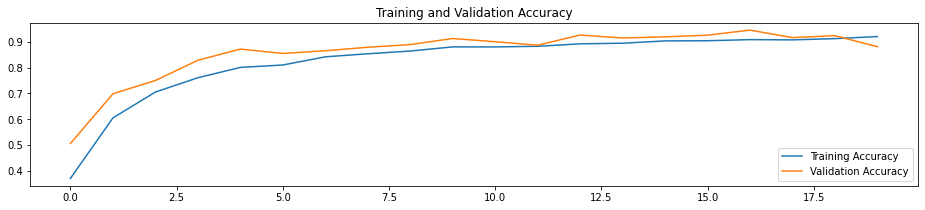

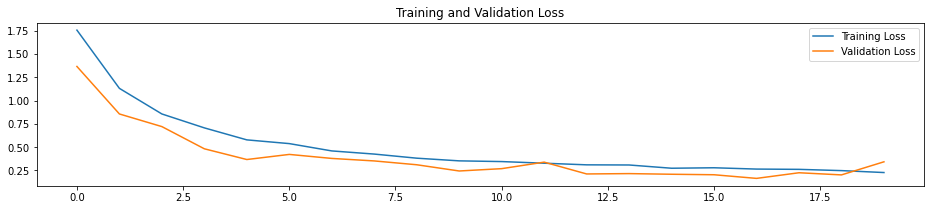

In [37]:
plt.figure(figsize=(35,3))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("Training and Validation Accuracy")
# plt.show()

plt.figure(figsize=(35,3))
plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend(loc = "upper right")
plt.title("Training and Validation Loss")
plt.show()

First image to predict----
First image's actual label: Tomato_Early_blight

Predition of Model
[6.7303044e-05 9.9992466e-01 1.4471593e-07 4.7903419e-15 3.4680058e-06
 5.9369881e-14 4.4145972e-06 7.8156937e-16 1.6409294e-23 5.0362793e-19]
1
First image's predicted label: Tomato_Early_blight


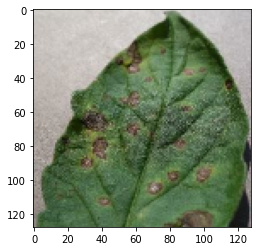

In [38]:
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = label_batch[0]
    
    print("First image to predict----")
    plt.imshow(first_image)
    print("First image's actual label:", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("\nPredition of Model")
    print(batch_prediction[0])
    print(np.argmax(batch_prediction[0]))
    print("First image's predicted label:",class_names[np.argmax(batch_prediction[0])])

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

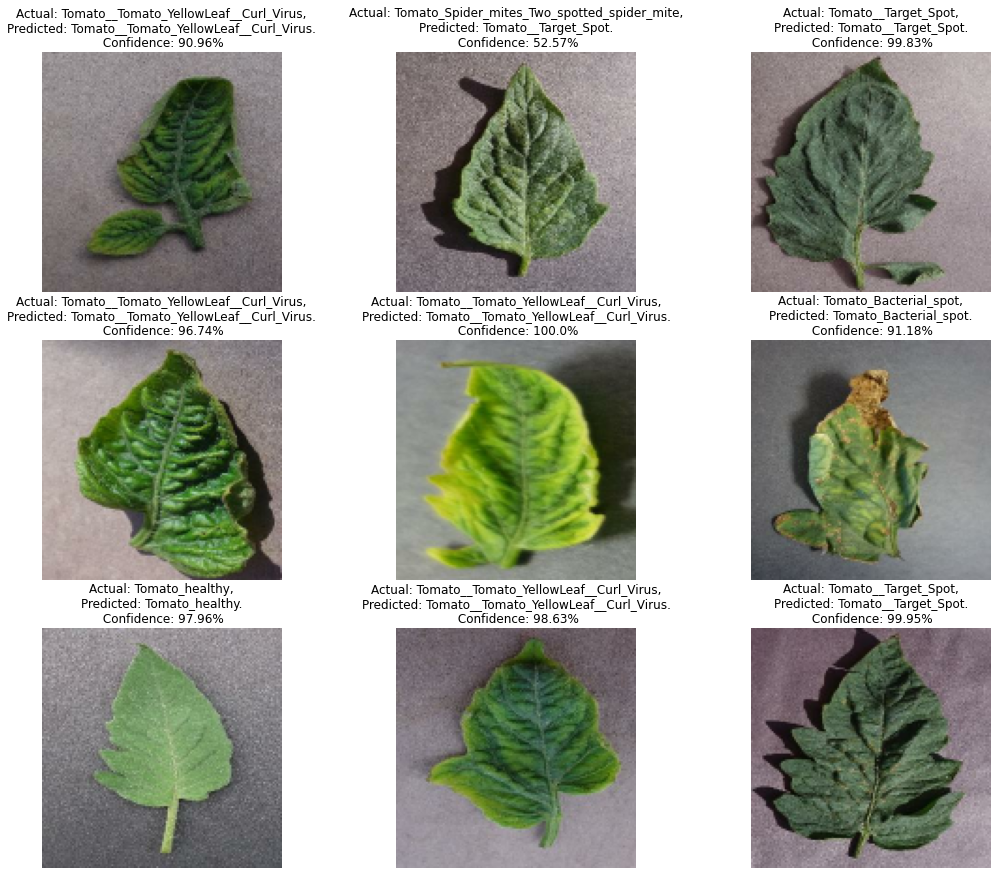

In [40]:
plt.figure(figsize=(18,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off") 

In [41]:
model_version="version_2"
model.save(f"saved_models/{model_version}", save_format="h5")